In [2]:
import phik
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, recall_score, precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score
from catboost import Pool
from sklearn.model_selection import train_test_split
from catboost import cv
from imblearn import over_sampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

**Заказчик**: кредитный отдел банка.  
**Входные данные от банка**: статистика о платёжеспособности клиентов.  
**Задача**: определить зависимости. Определить возможность обучения модели на данных.

## Изучение датасета

In [3]:
data = pd.read_csv('/datasets/data.csv')

### Знакомство с данными

In [4]:
print('Исходный датасет')
print(f'Количество строк {data.shape[0]}')
print(f'Количество столбцов {data.shape[1]}')

Исходный датасет
Количество строк 21525
Количество столбцов 12


In [5]:
data.head(7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем


В датасете содержится любопытная информация по возрасту, образованию, количеству детей, целям кредита, полу и специальности. Попробуем изучить каждый признак отдельно и сделать выводы об отсутствии либо наличии зависимостей с наличием просрочки по кредиту.

### Изучение столбцов

In [6]:
data.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

**Описание данных**  
**children** — количество детей в семье  
**days_employed** — общий трудовой стаж в днях  
**dob_years** — возраст клиента в годах  
**education** — уровень образования клиента  
**education_id** — идентификатор уровня образования  
**family_status** — семейное положение  
**family_status_id** — идентификатор семейного положения  
**gender** — пол клиента  
**income_type** — тип занятости  
**debt** — имел ли задолженность по возврату кредитов  
**total_income** — ежемесячный доход  
**purpose** — цель получения кредита  

### Дубликаты

Определим количество полных дубликатов в исходном датасете.

In [7]:
mydups = data.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 54


Удалим полные дубликаты из датасета.

In [8]:
data = data.drop_duplicates()
mydups = data.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 0


### Диапазон значений

Изучим предложенные диапазоны числовых значений в датасете.

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
children,21471.0,0.539565,1.382978,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
dob_years,21471.0,43.279074,12.574291,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21471.0,0.817195,0.548508,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21471.0,0.973685,1.421082,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21471.0,0.081086,0.272974,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


В двух столбцах присутствуют пропуски.  
Средний возраст заемщика - **43** года.  
**8%** заемщиков уходят в просрочку.

### Пропуски

In [10]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('bwr')

,0
children,0.000000
days_employed,9.900000
dob_years,0.000000
education,0.000000
education_id,0.000000
family_status,0.000000
family_status_id,0.000000
gender,0.000000
income_type,0.000000
debt,0.000000


В столбце о доходе и трудовом стаже обнаружены пропуски, их доля 10%. Изучим несколько подобных строк.

In [11]:
data.query('days_employed.isnull()').head(7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи


Пропуски по трудовому стажу отсуствуют там же где и пропуски по доходу. При этом остальные признаки заемщика заполнены, то есть могут быть использованы не в контексте изучения этих метрик. Оставим пропуски в датасете.

### Корреляция

In [12]:
data.corr()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
children,1.000000,-0.138354,-0.173885,-0.012477,-0.091435,0.018336,0.018220
days_employed,-0.138354,1.000000,0.582643,0.080565,0.005726,-0.047110,-0.136648
dob_years,-0.173885,0.582643,1.000000,0.066885,-0.069684,-0.069379,-0.052911
education_id,-0.012477,0.080565,0.066885,1.000000,0.007990,0.052964,-0.178885
family_status_id,-0.091435,0.005726,-0.069684,0.007990,1.000000,0.020389,-0.009147
debt,0.018336,-0.047110,-0.069379,0.052964,0.020389,1.000000,-0.012475
total_income,0.018220,-0.136648,-0.052911,-0.178885,-0.009147,-0.012475,1.000000


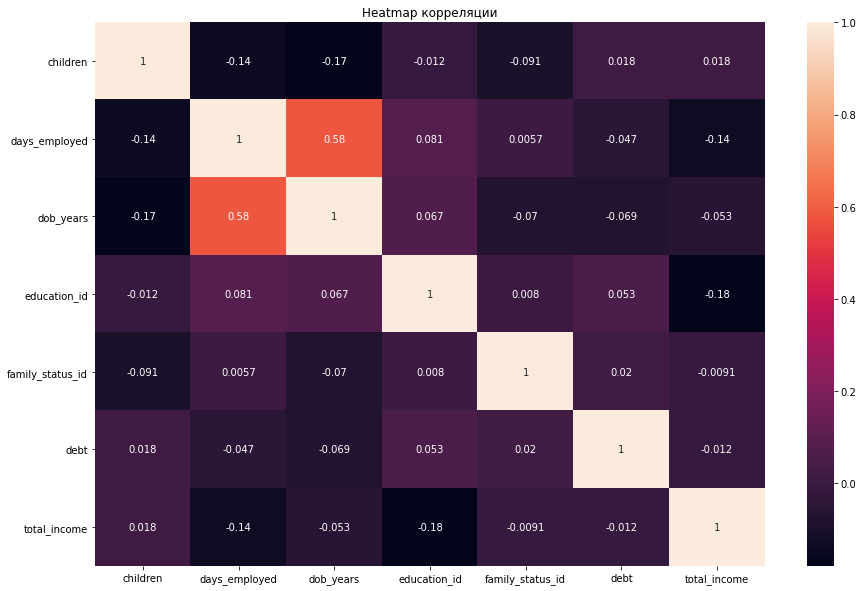

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True)
plt.title('Heatmap корреляции')
plt.show()

На данном этапе наибольшая корреляция к задолженности выявлена по возрасту. Чуть ниже значения корреляции по рабочему стажу.

### PHIK

In [14]:
phik_overview = data.phik_matrix()

interval columns not set, guessing: ['children', 'days_employed', 'dob_years', 'education_id', 'family_status_id', 'debt', 'total_income']


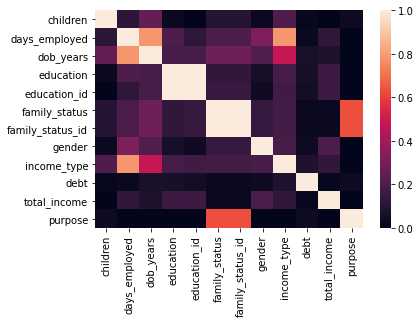

In [15]:
sns.heatmap(phik_overview)
plt.show()

In [16]:
phik_overview['debt'].sort_values(ascending=False).reset_index().style.background_gradient('gist_ncar')
 

,index,debt
0,debt,1.000000
1,income_type,0.084100
2,dob_years,0.068540
3,education,0.062643
4,education_id,0.047347
5,gender,0.033514
6,purpose,0.031848
7,days_employed,0.028523
8,family_status,0.027509
9,family_status_id,0.027509


Значения PHIK еще меньше. Сильных линейных зависимостей не выявлено.

## Предобработка

### Тип образования заемщика

In [17]:
data['education'].unique() 

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

В столбце с типом образования обнаружены одинаковые типы написанные в разных регистрах. Приведем всё к единому стилю.

In [18]:
data['education'] = data['education'].str.lower()

In [19]:
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

In [20]:
data['education'].value_counts().reset_index() 

,index,education
0,среднее,15188
1,высшее,5251
2,неоконченное высшее,744
3,начальное,282
4,ученая степень,6


Аномалий не выявлено, распределение выглядит логичным.

### Цель кредита

In [21]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

В столбце с целью кредита проблемы с регистром не обнаружены, зато обнаружено отсуствие конкретных категорий, одни и те же цели могут быть написаны разными формулировками. В целях оптимизации информации напишем функцию, которая разбирает по категориям каждую формулировку и положим эти значения в новый столбец.

In [22]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'автомобиль'
        elif 'жил' in row or 'недвиж' in row:
            return 'недвижимость'
        elif 'свад' in row:
            return 'свадьба'
        elif 'образов' in row:
            return 'образование'
    except:
        return 'нет категории'

In [23]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

In [24]:
data['purpose_category'].value_counts(dropna=False).reset_index()

,index,purpose_category
0,недвижимость,10814
1,автомобиль,4308
2,образование,4014
3,свадьба,2335


Цели кредита определены, пропусков нет.

### Пол заёмщика

In [25]:
data['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

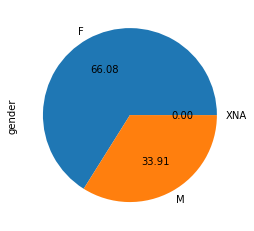

In [26]:
data['gender'].value_counts().plot.pie(autopct='%.2f')
plt.show()

In [27]:
data['gender'].value_counts().reset_index()

,index,gender
0,F,14189
1,M,7281
2,XNA,1


В столбце обнаружена одна строка с непонятным полом. Изучим её.

In [28]:
data_exam = data.query('gender =="XNA"')
data_exam

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
10701,0,-2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости,недвижимость


По указанным признакам не получается определить пол заёмщика. Удалим строку из датасета.

In [29]:
data = data.query('gender !="XNA"')
len(data)

21470

### Тип занятости заёмщика

In [30]:
data['income_type'].unique()

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

In [31]:
data['income_type'].value_counts().reset_index()

,index,income_type
0,сотрудник,11091
1,компаньон,5079
2,пенсионер,3837
3,госслужащий,1457
4,безработный,2
5,предприниматель,2
6,в декрете,1
7,студент,1


Аномалий не выявлено, распределение выглядит логичным.

### Семейный статус

In [32]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [33]:
data['family_status'] = data['family_status'].str.lower()

In [34]:
data['family_status'].value_counts()

женат / замужем          12344
гражданский брак          4162
не женат / не замужем     2810
в разводе                 1195
вдовец / вдова             959
Name: family_status, dtype: int64

В данном столбце исправлена одна категория в части регистра. В остальном аномалий и ошибок не выявлено.

### Количество детей

In [35]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

Значения "-1" и "20" детей выглядят как аномалии или технические ошибки

In [36]:
data['children'].value_counts().reset_index()

,index,children
0,0,14106
1,1,4809
2,2,2052
3,3,330
4,20,76
5,-1,47
6,4,41
7,5,9


Посмотрим строки по заемщикам со значением "-1".

In [37]:
data_exam = data.query('children == -1')
data_exam.head(7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
291,-1,-4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование,образование
705,-1,-902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля,автомобиль
742,-1,-3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование,образование
800,-1,349987.852217,54,среднее,1,не женат / не замужем,4,F,пенсионер,0,86293.724153,дополнительное образование,образование
941,-1,NaN,57,среднее,1,женат / замужем,0,F,пенсионер,0,NaN,на покупку своего автомобиля,автомобиль
1363,-1,-1195.264956,55,среднее,1,женат / замужем,0,F,компаньон,0,69550.699692,профильное образование,образование
1929,-1,-1461.303336,38,среднее,1,не женат / не замужем,4,M,сотрудник,0,109121.569013,покупка жилья,недвижимость


In [38]:
print(f'Средний возраст по срезу {data_exam["dob_years"].mean()}')
print(f'Количество заемщиков в выборке {len(data_exam)}')

Средний возраст по срезу 42.57446808510638
Количество заемщиков в выборке 47


47 человек со средним возрастом 42,5 года.
Предположим, что в данном столбце техническая ошибка и минус 1 по факту является 1 ребенком. Заменим значения на корректные.

In [39]:
data['children'] = data['children'].replace(-1, 1)

Изучим заемщиком со значением "20" детей.

In [40]:
data_exam = data.query('children == 20')
data_exam.head(7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
606,20,-880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья,недвижимость
720,20,-855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости,недвижимость
1074,20,-3310.411598,56,среднее,1,женат / замужем,0,F,сотрудник,1,229518.537004,получение образования,образование
2510,20,-2714.161249,59,высшее,0,вдовец / вдова,2,F,сотрудник,0,264474.835577,операции с коммерческой недвижимостью,недвижимость
2941,20,-2161.591519,0,среднее,1,женат / замужем,0,F,сотрудник,0,199739.941398,на покупку автомобиля,автомобиль
3302,20,NaN,35,среднее,1,не женат / не замужем,4,F,госслужащий,0,NaN,профильное образование,образование
3396,20,NaN,56,высшее,0,женат / замужем,0,F,компаньон,0,NaN,высшее образование,образование


In [41]:
print(f'Средний возраст по срезу {data_exam["dob_years"].mean()}')
print(f'Количество заемщиков в выборке {len(data_exam)}')

Средний возраст по срезу 41.81578947368421
Количество заемщиков в выборке 76


Средний возраст 76 заёмщиков в срезе 41.8. Заменим 20 на 2.

In [42]:
data['children'] = data['children'].replace(20, 2)

In [43]:
data['children'].value_counts().reset_index()

,index,children
0,0,14106
1,1,4856
2,2,2128
3,3,330
4,4,41
5,5,9


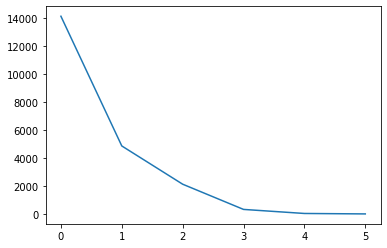

In [44]:
data['children'].value_counts().plot()
plt.show()

Некорректные значения скорректированы. Финальное распределение выглядит логичным.

### Возраст

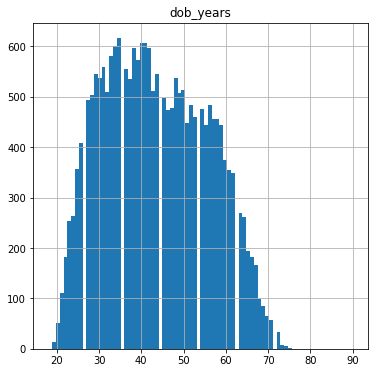

In [45]:
data.hist('dob_years', bins=80, range=(18, 90), figsize=(6,6))
plt.show()

In [46]:
data['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

Все значения находятся в пределах допустимого диапазона, но есть нули. Посмотрим сколько их.

In [47]:
len(data.loc[data['dob_years'] == 0])

101

In [48]:
data_exam = data.query('dob_years == 0')
data_exam.head(7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category
99,0,346541.618895,0,среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль,автомобиль
149,0,-2664.273168,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем,недвижимость
270,3,-1872.663186,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью,недвижимость
578,0,397856.565013,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости,недвижимость
1040,0,-1158.029561,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль,автомобиль
1149,0,-934.654854,0,среднее,1,женат / замужем,0,F,компаньон,0,201852.430096,покупка недвижимости,недвижимость
1175,0,370879.508002,0,среднее,1,женат / замужем,0,F,пенсионер,0,313949.845188,получение дополнительного образования,образование


Судя по срезу это техническая ошибка, а не младенцы. Замени 0 на медиану.

In [49]:
data_exam = data.query('dob_years > 18')
len(data_exam)

21369

In [50]:
print(f'Среднее по датасету без нулей: {data_exam["dob_years"].mean()})')
print(f'Медиана по датасету без нулей: {data_exam["dob_years"].median()}')

Среднее по датасету без нулей: 43.48453367027002)
Медиана по датасету без нулей: 43.0


In [51]:
data['dob_years'] = data['dob_years'].replace(0, data_exam["dob_years"].median())

In [52]:
data['dob_years'].unique()

array([42., 36., 33., 32., 53., 27., 43., 50., 35., 41., 40., 65., 54.,
       56., 26., 48., 24., 21., 57., 67., 28., 63., 62., 47., 34., 68.,
       25., 31., 30., 20., 49., 37., 45., 61., 64., 44., 52., 46., 23.,
       38., 39., 51., 59., 29., 60., 55., 58., 71., 22., 73., 66., 69.,
       19., 72., 70., 74., 75.])

Нули исправлены, аномалий не выявлено.

### Стаж

In [53]:
data['days_employed'].head(15)

0      -8437.673028
1      -4024.803754
2      -5623.422610
3      -4124.747207
4     340266.072047
5       -926.185831
6      -2879.202052
7       -152.779569
8      -6929.865299
9      -2188.756445
10     -4171.483647
11      -792.701887
12              NaN
13     -1846.641941
14     -1844.956182
Name: days_employed, dtype: float64

В столбце обнаружены минусовые значения. Предположим, что это техническая ошибка и заменим - на +.

In [54]:
data['days_employed'] = data['days_employed'].abs()

In [55]:
data['days_employed'].head(10)

0      8437.673028
1      4024.803754
2      5623.422610
3      4124.747207
4    340266.072047
5       926.185831
6      2879.202052
7       152.779569
8      6929.865299
9      2188.756445
Name: days_employed, dtype: float64

Максимальное значение 401755.40047533
Минимальное значение 24.14163324048118


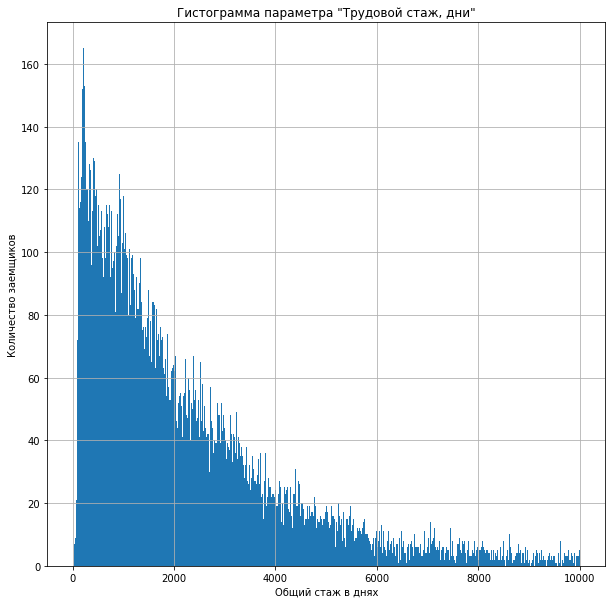

In [56]:
data.hist('days_employed', bins=500, range=(0, 10000), figsize=(10,10))
plt.title('Гистограмма параметра "Трудовой стаж, дни"')
plt.xlabel('Общий стаж в днях')
plt.ylabel('Количество заемщиков')
print('Максимальное значение', data['days_employed'].max())
print('Минимальное значение', data['days_employed'].min())

Распределение по стажу выглядит логично, больше всего заемщиков с околонулевым стажом, чем больше стажа, тем отчётливее снижение. При этом есть алогичные выбросы в диапозоне от 10 000 дней стажа.
Предположим, что 50 лет это максимально возможный стаж из расчёта 20 + 50 = 75 лет. Сколько заемщиков в датасете со стажем больше этого значения?

In [57]:
data_exam = data.query('days_employed > 50 * 365')
data_exam.shape

(3446, 13)

В датасете обнаружено 3445 строчек с общим трудовым стажем больше 65 лет. Это маловероятно. Вероятно человеческа ошибка при вводе или техническая при расчете. 

In [58]:
data_exam['income_type'].value_counts().reset_index()

,index,income_type
0,пенсионер,3443
1,безработный,2
2,сотрудник,1


Некорректный стаж указан в основном у пенсионеров. Всего пенсионеров больше 3 800 ни них 3 400 это неправильный стаж.  

In [59]:
data_pens = data.query('income_type == "пенсионер"')
len(data_pens)

3837

Максимальное значение 401755.40047533
Минимальное значение 328728.72060451825
Среднее значение 365003.4912448612
Медиана 365213.3062657312


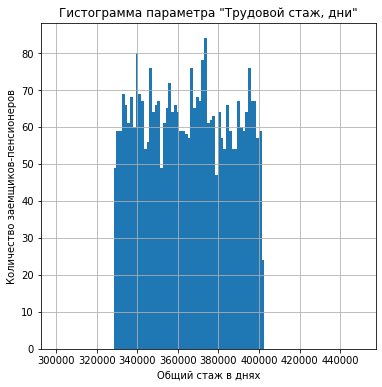

In [60]:
data_pens['days_employed'].unique()
data_pens.hist('days_employed', bins=111, range=(300000, 450000), figsize=(6,6))
plt.title('Гистограмма параметра "Трудовой стаж, дни"')
plt.xlabel('Общий стаж в днях')
plt.ylabel('Количество заемщиков-пенсионеров')
print('Максимальное значение', data_pens['days_employed'].max())
print('Минимальное значение', data_pens['days_employed'].min())
print('Среднее значение', data_pens['days_employed'].mean())
print('Медиана', data_pens['days_employed'].median())

Основной массив значения лежит в диапазоне от 300 000 до 420 000 дней.  
Вероятно это техническая ошибка.  


In [61]:
data_exam = data.query('income_type != "пенсионер"')
data_exam['days_employed'].sort_values(ascending=False).head(15)

14798    395302.838654
3133     337524.466835
16335     18388.949901
4299      17615.563266
7329      16593.472817
17838     16264.699501
16825     16119.687737
3974      15835.725775
1539      15785.678893
4321      15773.061335
7731      15618.063786
15675     15410.040779
19788     15267.541183
16868     15193.032201
5581      15079.216069
Name: days_employed, dtype: float64

Хвостик неаномального стажа заканчивается в районе 15-18 тысяч дней, что соотвествует 40-45 годам. 
Поставим всем пенсионерам максимальный стаж в указанном диапазоне с помощью функции.

In [62]:
import random
def pens_emp(row):
    days_emp = random.randint(10000, 18000)
    if row['income_type'] == "пенсионер":
        return days_emp
    return row['days_employed']

In [63]:
data['true_days'] = data.apply(pens_emp, axis=1)
data.head(7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_category,true_days
0,1,8437.673028,42.0,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,недвижимость,8437.673028
1,1,4024.803754,36.0,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,автомобиль,4024.803754
2,0,5623.422610,33.0,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,недвижимость,5623.422610
3,3,4124.747207,32.0,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,образование,4124.747207
4,0,340266.072047,53.0,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу,свадьба,10318.000000
5,0,926.185831,27.0,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,недвижимость,926.185831
6,0,2879.202052,43.0,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем,недвижимость,2879.202052


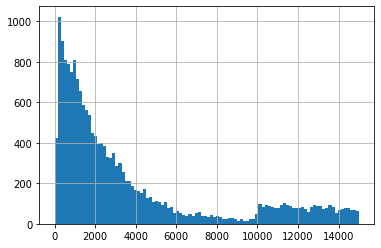

In [64]:
data['true_days'].hist(bins=100, range=(1,15000))
plt.show()

Применён эксперементальный метод исправления данных по пенсионерам для дальнейшего использования в машинном изучении.

### Зарплата

Максимальное значение 2265604.028722744
Минимальное значение 20667.26379327158
Среднее значение 167420.41678930717
Медиана 145011.70929552132


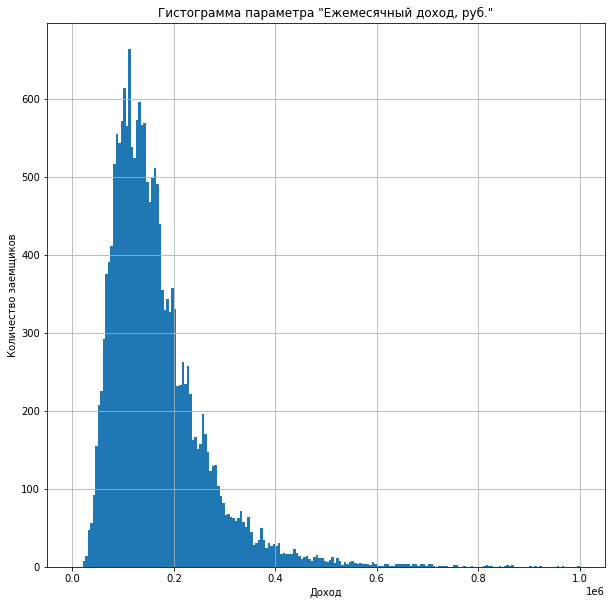

In [65]:
data.hist('total_income', bins=200, range=(0, 1000000), figsize=(10,10))
plt.title('Гистограмма параметра "Ежемесячный доход, руб."')
plt.xlabel('Доход')
plt.ylabel('Количество заемщиков')
print('Максимальное значение', data['total_income'].max())
print('Минимальное значение', data['total_income'].min())
print('Среднее значение', data['total_income'].mean())
print('Медиана', data['total_income'].median())

Распределение является нормальным. Аномалий не обнаружено.  
Среднее значение 167 тыс.руб.  
Медиана 145 тыс. руб.

**Финальная проверка на дубликаты**

In [66]:
mydups = data.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)
data = data.drop_duplicates()
mydups = data.duplicated().sum()
print('Количество полных дубликтов в датасете', mydups)

Количество полных дубликтов в датасете 9
Количество полных дубликтов в датасете 0


## Анализ

### Пол заемщика

In [67]:
data.groupby('gender')['debt'].agg(['count', 'mean'])

,count,mean
gender,,
F,14182,0.070089
M,7279,0.102624


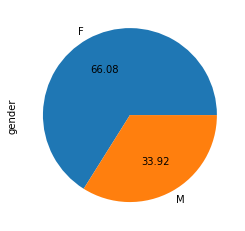

In [68]:
data['gender'].value_counts().plot.pie(autopct='%.2f')
plt.show()

**Наблюдение 1**  
Клиентский портфель банка на две трети состоит из женщин.  При этом женщины-заёмщики показывают значительно большую надежность, по сравнению с мужчинами.
Рассмотрим остальные параментры в контексте пола заемщиков для более детального поиска зависимостей.

Для дальнейшего удобства разделим датафрейм по гендеру.

In [69]:
w_df = data.query('gender == "F"').copy()
m_df = data.query('gender == "M"').copy()

### Возраст

In [70]:
print('Средний возраст заемщика', data['dob_years'].mean())
print('Медианый возраст заемщика', data['dob_years'].median())
print('Средний возраст мужчин', m_df['dob_years'].mean())
print('Медианый возраст мужчин', m_df['dob_years'].median())
print('Средний возраст женщин', w_df['dob_years'].mean())
print('Медианый возраст женщи', w_df['dob_years'].median())

Средний возраст заемщика 43.482176972182096
Медианый возраст заемщика 43.0
Средний возраст мужчин 41.15441681549663
Медианый возраст мужчин 40.0
Средний возраст женщин 44.676914398533356
Медианый возраст женщи 44.0


Так как диапазон возрастов заемщиков довольно широк применим функцию, которая создать дополнительный столбец с сегментам по возрасту. Сегменты возьмём типовые 6-летние.

In [71]:
def categorize_age(age):
    if age > 17 and age <24:
        return '1. 18-24'
    elif age >= 24 and age <30:
        return '2. 24-30'
    elif age >= 30 and age <36:
        return '3. 30-36'
    elif age >= 36 and age <42:
        return '4. 36-42'
    elif age >= 42 and age <48:
        return '5. 42-48'
    elif age >= 48 and age <54:
        return '6. 48-54'
    elif age >= 54 and age <60:
        return '7. 54 - 60'
    elif age >= 60:
        return '8. 60+'
    elif age == 0:
        return '9. 0'
data['age_group'] = data['dob_years'].apply(categorize_age)

In [72]:
data.groupby(['age_group'])['debt'].agg(['count', 'mean'])

,count,mean
age_group,,
1. 18-24,611,0.104746
2. 24-30,2568,0.110981
3. 30-36,3403,0.102557
4. 36-42,3471,0.086430
5. 42-48,3199,0.078149
6. 48-54,2946,0.067549
7. 54 - 60,2757,0.062024
8. 60+,2506,0.049082


Справедливо сравнивать группы 2-8 и исключить из сравнения группу 1 из-за малой выборки.  
**Группы 2 - 8 демонстрируют четкую линейную зависимость**: чем старше человек, тем ниже вероятность уйти в просрочку.  
Рассмотрим эти же показатели в части гендера.

In [73]:
data.groupby(['age_group','gender'])['debt'].agg(['count', 'mean'])

count      mean
age_group  gender                 
1. 18-24   F         345  0.081159
           M         266  0.135338
2. 24-30   F        1475  0.102373
           M        1093  0.122598
3. 30-36   F        2039  0.099559
           M        1364  0.107038
4. 36-42   F        2200  0.078636
           M        1271  0.099921
5. 42-48   F        2100  0.064762
           M        1099  0.103731
6. 48-54   F        2049  0.057589
           M         897  0.090301
7. 54 - 60 F        2043  0.049927
           M         714  0.096639
8. 60+     F        1931  0.042983
           M         575  0.069565

**Наблюдение 2**  
Возраст человека влияет на вероятность выхода в просрочку. Чеш выше возраст, тем меньше вероятность. При более детальном изучении возраста выяснилось, что кол-во женщин в группах 3-8 практически одинаковое, а вот количество мужчин снижается от группы к группе. Вероятно высокий показатель по мужскому полу связан не только с гендерными особенностями, но и с тем, что мужской портфель банка моложе женского.

### Образование

In [74]:
data.groupby('education')['debt'].agg(['count', 'mean'])

,count,mean
education,,
высшее,5251,0.052942
начальное,282,0.109929
неоконченное высшее,743,0.091521
среднее,15179,0.089861
ученая степень,6,0.000000


In [75]:
data.groupby(['education','gender'])['debt'].agg(['count', 'mean'])

count      mean
education           gender                 
высшее              F        3540  0.047175
                    M        1711  0.064874
начальное           F         163  0.098160
                    M         119  0.126050
неоконченное высшее F         460  0.089130
                    M         283  0.095406
среднее             F       10017  0.076869
                    M        5162  0.115072
ученая степень      F           2  0.000000
                    M           4  0.000000

**Наблюдение 3**  
Наиболее надёжными в контексте образования являются заемщики с высшим образованием.  
Наиболее не надёжными заемщики с начальным образованием.  
Надежность заемщиков со средним и неоконченным высшим образованием выше, чем с начальным, но значительно уступает заемщикам с высшим.  
По заёмщикам с ученой степенью невозможно сделать вывод в связи с малой выборкой.  
Надежность заемщиков с неоконченным высшим практически не отличается, но малой размер выборки и влияние других факторов не позволяет сделать выводы о малой корреляции в данной группе.

### Дети

In [76]:
data.groupby('children')['debt'].agg(['count', 'mean'])

,count,mean
children,,
0,14098,0.075401
1,4855,0.091658
2,2128,0.094925
3,330,0.081818
4,41,0.097561
5,9,0.000000


In [77]:
data.groupby(['children','gender'])['debt'].agg(['count', 'mean'])

count      mean
children gender                 
0        F        9528  0.062133
         M        4570  0.103063
1        F        3120  0.078846
         M        1735  0.114697
2        F        1303  0.105909
         M         825  0.077576
3        F         196  0.086735
         M         134  0.074627
4        F          28  0.035714
         M          13  0.230769
5        F           7  0.000000
         M           2  0.000000

**Наблюдение 4**  
Наличие детей увеличивает риск уйти в просрочку.  
Чем больше детей, тем выше вероятность просрочки.  
При этом более детальное изучение данного атрибута в части гендера выявило интересную закономерность. Женщины с двумя детьми наиболее рисковый сегмент в части ухода в просрочку. В данной группе женщины по вероятности значительно выше мужчин, хотя в остальных группах вероятность по мужчинам всегда выше.

### Семейное положение

In [78]:
data.groupby('family_status')['debt'].agg(['count', 'mean'])

,count,mean
family_status,,
в разводе,1195,0.071130
вдовец / вдова,959,0.065693
гражданский брак,4156,0.093359
женат / замужем,12341,0.075440
не женат / не замужем,2810,0.097509


In [79]:
data.groupby(['family_status','gender'])['debt'].agg(['count', 'mean'])

count      mean
family_status         gender                 
в разводе             F         936  0.065171
                      M         259  0.092664
вдовец / вдова        F         904  0.057522
                      M          55  0.200000
гражданский брак      F        2851  0.081726
                      M        1305  0.118774
женат / замужем       F        7762  0.068281
                      M        4579  0.087574
не женат / не замужем F        1729  0.068248
                      M        1081  0.144311

**Наблюдение 5**  
Самыми надежным заёмщиками являются вдовы.  
Cамыми ненадежными - не женатые мужчины.  
**Интересный факт:**  Показатель надежности у женщин в браке и не замужем практически одинаков, а у мужчин отличается почти в два раза.

### Цель кредита

In [80]:
data.groupby('purpose_category')['debt'].agg(['count', 'mean'])

,count,mean
purpose_category,,
автомобиль,4307,0.093569
недвижимость,10810,0.072340
образование,4014,0.092177
свадьба,2330,0.079828


In [81]:
data.groupby(['purpose_category','gender'])['debt'].agg(['count', 'mean'])

count      mean
purpose_category gender                 
автомобиль       F        2861  0.082139
                 M        1446  0.116183
недвижимость     F        7085  0.062668
                 M        3725  0.090738
образование      F        2668  0.077586
                 M        1346  0.121100
свадьба          F        1568  0.068878
                 M         762  0.102362

**Наблюдение 6**  
Наиболее надежный сегмент - кредиты на недвижимость. Наиболее надежный клиент - женщина берущая ипотеку. Далее в порядке увеличения вероятности - женщина-заемщик на свадьбу, образование, автомобиль. Мужчины идут со значительным отставанием по всем категориям.

### Тип занятости

In [82]:
data.groupby('income_type')['debt'].agg(['count', 'mean'])

,count,mean
income_type,,
безработный,2,0.500000
в декрете,1,1.000000
госслужащий,1457,0.059025
компаньон,5077,0.074059
пенсионер,3837,0.056294
предприниматель,2,0.000000
сотрудник,11084,0.095724
студент,1,0.000000


In [83]:
data.groupby(['income_type','gender'])['debt'].agg(['count', 'mean'])

count      mean
income_type     gender                 
безработный     F           1  0.000000
                M           1  1.000000
в декрете       F           1  1.000000
госслужащий     F        1072  0.054104
                M         385  0.072727
компаньон       F        3191  0.066123
                M        1886  0.087487
пенсионер       F        3140  0.052548
                M         697  0.073171
предприниматель F           1  0.000000
                M           1  0.000000
сотрудник       F        6776  0.082497
                M        4308  0.116527
студент         M           1  0.000000

**Наблюдение 7**  
Наиболее надежные заёмщики - женщины: пенсионеры и госслужащие.  
Наименее надежные заёмщики - мужчины: сотрудники.

### Доход

Так как доход это количественная переменная применим функцию и создадим доп.столбец для разделения по аналогии с возрастом.

In [84]:
def categorize_money(salary):
    if salary > 0 and salary < 30000:
        return '1. до 30 тыс.'
    elif salary >= 30000 and salary < 50000:
        return '2. 30-50 тыс'
    elif salary >= 50000 and salary <75000:
        return '3. 50-75 тыс'
    elif salary >= 75000 and salary <100000:
        return '4. 75-100 тыс'
    elif salary >= 100000 and salary <150000:
        return '5. 100-150 тыс'
    elif salary >= 150000 and salary <250000:
        return '6. 150-250 тыс'
    elif salary >= 250000 and salary <500000:
        return '7. 250-500 тыс'
    elif salary >= 500000:
        return '8. 500 тыс +'
data['salary_group'] = data['total_income'].apply(categorize_money)

In [85]:
data.groupby('salary_group')['debt'].agg(['count', 'mean'])

,count,mean
salary_group,,
1. до 30 тыс.,22,0.090909
2. 30-50 тыс,350,0.060000
3. 50-75 тыс,1493,0.075687
4. 75-100 тыс,2598,0.083911
5. 100-150 тыс,5704,0.086080
6. 150-250 тыс,6371,0.083503
7. 250-500 тыс,2590,0.069498
8. 500 тыс +,222,0.063063


In [86]:
data.groupby(['salary_group','gender'])['debt'].agg(['count', 'mean'])

count      mean
salary_group   gender                 
1. до 30 тыс.  F          16  0.125000
               M           6  0.000000
2. 30-50 тыс   F         309  0.048544
               M          41  0.146341
3. 50-75 тыс   F        1220  0.068033
               M         273  0.109890
4. 75-100 тыс  F        2014  0.075968
               M         584  0.111301
5. 100-150 тыс F        3977  0.074177
               M        1727  0.113492
6. 150-250 тыс F        3752  0.067431
               M        2619  0.106529
7. 250-500 тыс F        1374  0.064047
               M        1216  0.075658
8. 500 тыс +   F          90  0.066667
               M         132  0.060606

**Наблюдение 8**  
У женщины наиболее рисковым является диапазон дохода - 75-150 тыс.руб. Наименее рисковый диапазоны 250-500 тыс.руб.
У мужчин наиболее рисковый сегмент  - 75-150 тыс.руб. Наименее рисковый - 250+ тыс.руб.

### Трудовой стаж

Так как доход это количественная переменная применим функцию и создадим доп.столбец для разделения по аналогии с возрастом. Так как по пенсионерам был выявлен неадекватный стаж отфильтруем их из выборки. Создадим новый столбец, в котором будем указывать стаж в годах.

In [87]:
data['years_emp'] = data['true_days'] / 365

In [88]:
def categorize_emp(years):
    if years > 0 and years < 2:
        return '1. до 2ух лет.'
    elif years >= 2 and years < 5:
        return '2. 2 - 5 лет'
    elif years >= 5 and years <10:
        return '3. 5-10 лет'
    elif years >= 10 and years <15:
        return '4. 10-15 лет'
    elif years >= 15 and years <25:
        return '5. 15-25 лет'
    elif years >= 25 and years <35:
        return '6. 25-35 лет'
    elif years >= 35 and years <45:
        return '7. 35-45 лет'
    elif years >= 45 and years <55:
        return '8. 45-55 лет'
    elif years >= 55:
        return '9. 55+'
data['years_emp_group'] = data['years_emp'].apply(categorize_emp)

In [89]:
data.groupby('years_emp_group')['debt'].agg(['count', 'mean'])

,count,mean
years_emp_group,,
1. до 2ух лет.,3850,0.111948
2. 2 - 5 лет,4788,0.093776
3. 5-10 лет,4118,0.084264
4. 10-15 лет,1714,0.060093
5. 15-25 лет,1055,0.044550
6. 25-35 лет,1684,0.054038
7. 35-45 лет,1826,0.049836
8. 45-55 лет,707,0.065064
9. 55+,2,0.500000


In [90]:
data.groupby(['years_emp_group','gender'])['debt'].agg(['count', 'mean'])

count      mean
years_emp_group gender                 
1. до 2ух лет.  F        2270  0.099559
                M        1580  0.129747
2. 2 - 5 лет    F        2867  0.075689
                M        1921  0.120770
3. 5-10 лет     F        2619  0.081329
                M        1499  0.089393
4. 10-15 лет    F        1131  0.054819
                M         583  0.070326
5. 15-25 лет    F         745  0.037584
                M         310  0.061290
6. 25-35 лет    F        1351  0.052554
                M         333  0.060060
7. 35-45 лет    F        1520  0.046053
                M         306  0.068627
8. 45-55 лет    F         582  0.060137
                M         125  0.088000
9. 55+          F           1  0.000000
                M           1  1.000000

**Наблюдение 9**  
Выявлена тендеция - чем выше стаж, тем меньше вероятность просрочки. 
При изучении групп по стажу в сегменте пола заемщика во всех группах надежность женщин выше надежности мужчин. Однако в группе 5-10 доля просрочки среди женщин и мужчин практически совпадают.

### Клиентский профиль

**По результатам EDA** разделим клиентский портфель банка на **2 сегмента:** 
1. Целевой
2. Рисковый  

В целевом перечислим **наименее** рисковые подсегменты клиентов. Те клиенты, риск ухода просрочки по которым минимален(по сравнению с средним показателем по портфелю).  
В рисковом укажем подсегменты клиентов, которые **более** склонны к уходу в просрочку.

✅**Целевой сегмент**✅

**Пол:** Женский - 7%(доля просрочки среди заёмщиков)  
**Возраст(лет):** 42-48 - 7,8%, 48-54 - 6,7%, 54-60 - 6,2%, 60+ - 4,9%  
**Образование:** высшее - 5,2%  
**Дети(шт):** нет детей - 7,5%  
**Семейное положение:** женат/замужем - 7,5%  
**Цель кредита:** недвижимость - 7,2%, свадьба - 7,9%  
**Тип занятости:**  пенсонер - 5,6%, госслужащий - 5,9%  
**Доход(руб):** 250-500 тыс. - 6,9%, 50-75 тыс. - 7,5%  
**Стаж(лет):**  10-15 - 6%, 15-25 - 4,4%  

❗️❗️**Рисковый сегмент**❗️❗️

**Пол:** Мужской - 10,2%(доля просрочки среди заёмщиков)  
**Возраст(лет):** 24-30 - 11,1%, 30-36 - 10,3%, 36-42 - 8,6%   
**Образование:** среднее - 5,2%  
**Дети(шт):** нет детей - 8,9%. *Отдельной группой(из за малой выборки) высокого риска - начальное и неоконченное высшее*    
**Семейное положение:** не женат/не замужем - 9,7%, гражданский брак - 9,3%  
**Цель кредита:** автомобиль - 9,3%, образование - 9,2%   
**Тип занятости:**  сотрудник - 9,6%  
**Доход(руб):** 75-100 тыс. - 8,4%, 100-150 тыс. - 8,6%, 150-250 тыс. - 8,3%    
**Стаж(лет):**  до двух лет - 11,1%, 2-5 лет - 9,4%, 5-10 лет - 8,4%    

⚠️**Особенности**⚠️  
**Пол**: две трети датасета - женщины  
**Возраст**: женщины однородно распределены по всем возрастным подсегментам. А вот у мужчин наблюдается непропорциональный дефицит представителей 45+  
**Дети**: в рамках исследования можно сделать четкий вывод только по заемщикам с 1 и 2 детьми. Заемщиков с детьми больше двух в датасете незначительное количество  
**Семейное положение**: наличие узаконенных отношений оказывает минимальное влияние на женщин-заемщиков. В любом из случаев доля просрочки в данном сегменте не более 6,9%. У мужчин ситуация обратная: 8,7% у женатых и более 14% у не женатых. Отдельно следует отметить, что количество вдов в датасете почти в 20 раз превышает количество вдовцев и не коррелирует с общими данными датасета. При этом именно по вдовам доле просрочки на минимальном уровне  
**Цель кредита**: кредит на свадьбы мы внесли в малорисковый сегмент в первую очередь за счёт женщин. А вот кредит на свадьбу для мужчин, как и кредит на образование это высокорисковый долг  
**Тип занятости**: непропорционально(относительно всего датасета) выглядит распределение по госслужащим (женщин больше в 3 раза), по пенсионерам (женщин больше в 4 раза)  
**Доход**: не удалось выявить зависимости "чем больше доход, тем меньше вероятность просрочки". В первую очередь вклда в это внесли мужчины, у которых в объединенном сегменте от 50 до 250 доля просрочки стабильно превышает 10%.  Максимальным значением у женщин является доля - 7,4%

## Машинное обучение

### Подготовка данных

**Пропуски**

In [91]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('magma')

,0
children,0.000000
days_employed,9.800000
dob_years,0.000000
education,0.000000
education_id,0.000000
family_status,0.000000
family_status_id,0.000000
gender,0.000000
income_type,0.000000
debt,0.000000


In [92]:
len(data)

21461

Уберем из датасета пропуски.

In [93]:
data_ml = data.query('total_income > 0')

In [94]:
len(data_ml)

19350

Датасет похудел на 10%. Посмотрим сколько было просрочников в строках с пропусками.

In [95]:
data_noml = data.query('total_income.isna()')
data_noml['debt'].mean()

0.08053055423969682

Аномалий нет. Показатель чуть ниже среднего по датасету. Исключения пропусков не искажает датасет по целвому признаку.

In [96]:
data_ml['debt'].mean()

0.08118863049095608

**Лишние столбцы**

Удалим бесполезные столбцы

In [97]:
data_ml = data_ml.drop(['education_id', 'family_status_id', 'purpose'], axis=1).copy()

Пропусков нет.

In [98]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19350 entries, 0 to 21524
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          19350 non-null  int64  
 1   days_employed     19350 non-null  float64
 2   dob_years         19350 non-null  float64
 3   education         19350 non-null  object 
 4   family_status     19350 non-null  object 
 5   gender            19350 non-null  object 
 6   income_type       19350 non-null  object 
 7   debt              19350 non-null  int64  
 8   total_income      19350 non-null  float64
 9   purpose_category  19350 non-null  object 
 10  true_days         19350 non-null  float64
 11  age_group         19350 non-null  object 
 12  salary_group      19350 non-null  object 
 13  years_emp         19350 non-null  float64
 14  years_emp_group   19350 non-null  object 
dtypes: float64(5), int64(2), object(8)
memory usage: 2.4+ MB


**Разделение выборки**

In [99]:
train, test = train_test_split(data_ml, train_size=0.6, random_state=1589, stratify=data_ml['debt'])
val, test = train_test_split(test, train_size=0.5, random_state=1589, stratify=test['debt'])

In [100]:
print(f'Доля таргета на обучении {train["debt"].mean()}')
print(f'Доля таргета на тесте {test["debt"].mean()}')
print(f'Доля таргета на валидации {val["debt"].mean()}')

Доля таргета на обучении 0.08122308354866495
Доля таргета на тесте 0.08113695090439277
Доля таргета на валидации 0.08113695090439277


In [101]:
print(f'Длина выборки на обучении {len(train)}')
print(f'Длина выборки на тесте {len(test)}')
print(f'Длина выборки на валидации {len(val)}')

Длина выборки на обучении 11610
Длина выборки на тесте 3870
Длина выборки на валидации 3870


**Функция подсчета эффективности модели**

In [102]:
def profit_model(target, predict):
    print(f'Accuracy: {accuracy_score(target, predict)}')
    print(f'Recall: {recall_score(target, predict)}')
    print(f'Precision: {precision_score(target, predict)}')
    print(f'F1: {f1_score(target, predict)}')

### Catboost 4 признака

In [103]:
X = ['children', 'true_days', 'dob_years', 'total_income']
y = ['debt']

In [104]:
params = {'verbose':100, 'random_seed':1589, 'learning_rate':0.01, 'eval_metric': 'AUC', 'auto_class_weights': 'Balanced'}
model = CatBoostClassifier(**params)
model.fit(train[X],train[y], eval_set=(val[X],val[y]))

0:	test: 0.5475410	best: 0.5475410 (0)	total: 52ms	remaining: 51.9s
100:	test: 0.5555243	best: 0.5588111 (6)	total: 433ms	remaining: 3.86s
200:	test: 0.5547075	best: 0.5588111 (6)	total: 820ms	remaining: 3.26s
300:	test: 0.5517655	best: 0.5588111 (6)	total: 1.23s	remaining: 2.86s
400:	test: 0.5507642	best: 0.5588111 (6)	total: 1.61s	remaining: 2.41s
500:	test: 0.5492211	best: 0.5588111 (6)	total: 1.98s	remaining: 1.97s
600:	test: 0.5463355	best: 0.5588111 (6)	total: 2.39s	remaining: 1.59s
700:	test: 0.5435673	best: 0.5588111 (6)	total: 2.79s	remaining: 1.19s
800:	test: 0.5408733	best: 0.5588111 (6)	total: 3.21s	remaining: 797ms
900:	test: 0.5393866	best: 0.5588111 (6)	total: 3.6s	remaining: 396ms
999:	test: 0.5381149	best: 0.5588111 (6)	total: 3.99s	remaining: 0us

bestTest = 0.5588110702
bestIteration = 6

Shrink model to first 7 iterations.


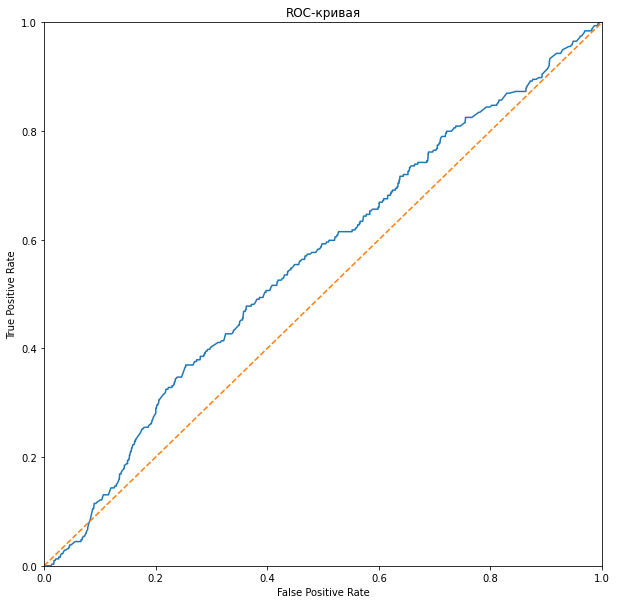

AUC: 0.558811070192659


In [105]:
probabilities_valid = model.predict_proba(val[X])
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(val[y], probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(val[y], probabilities_one_valid)

print("AUC:", auc_roc)

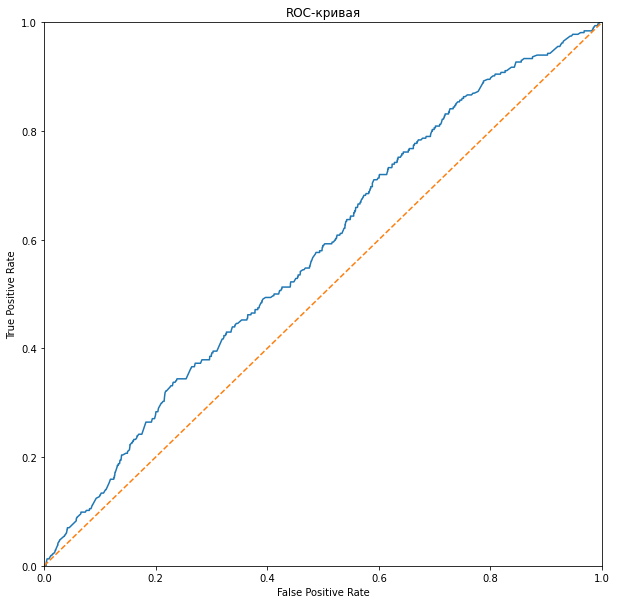

AUC: 0.5754851403924828


In [106]:
probabilities_test = model.predict_proba(test[X])
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(test[y], probabilities_one_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(test[y], probabilities_one_test)

print("AUC:", auc_roc)

In [107]:
n_iters = model.best_iteration_ + 1
params = {'verbose':100, 'random_seed':1589, 'learning_rate':0.1, 'eval_metric': 'AUC', 'iterations': n_iters}
model = CatBoostClassifier(**params)
model.fit(train[X],train[y])

0:	total: 2.62ms	remaining: 15.7ms
6:	total: 15.8ms	remaining: 0us


In [108]:
test['4_features'] = model.predict(test[X])

In [109]:
print(classification_report(test[y],test['4_features']))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3556
           1       0.00      0.00      0.00       314

    accuracy                           0.92      3870
   macro avg       0.46      0.50      0.48      3870
weighted avg       0.84      0.92      0.88      3870



In [110]:
profit_model(test['debt'], test['4_features'])

Accuracy: 0.9188630490956072
Recall: 0.0
Precision: 0.0
F1: 0.0


**Вывод**: Catboost переучился на 0. F1 и Accuracy на очень высоком уровне, но модели не удалось определить ни одного заёмщика.
Попробуем подобрать порог

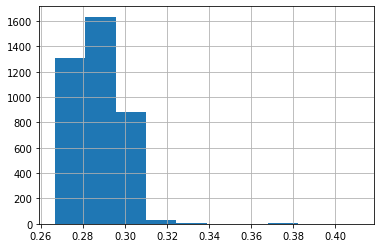

In [111]:
test['4_features_score'] = model.predict_proba(test[X])[:,1]
test['4_features_score'].hist()
plt.show()

In [112]:
roc_auc_score(test['debt'], test['4_features_score'])

0.5721302651658989

Порог = 0.12 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.121 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.122 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.123 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.124 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.125 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.126 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.127 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.128 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.129 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.13 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.131 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.132 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.133 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.134 | Точность = 0.081 Полнота = 1.0 | F1-мера = 0.15
Порог = 0.135 | Точность = 0.081 Полнота =

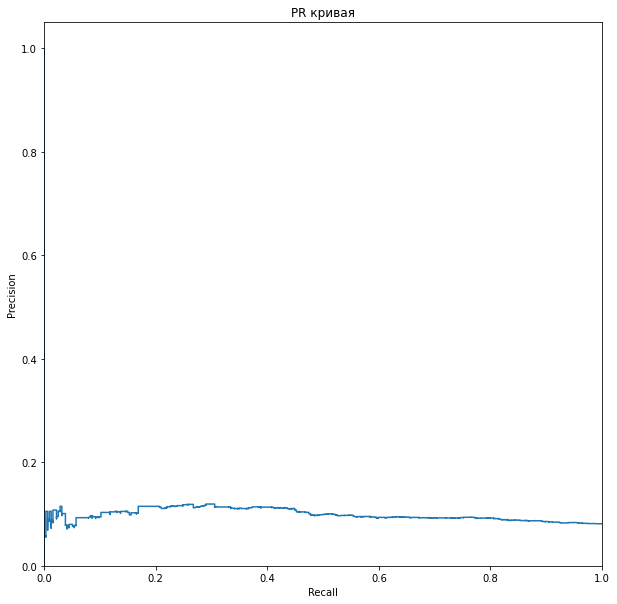

In [113]:
probabilities_valid = model.predict_proba(test[X])
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.12, 0.18, 0.001):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(test[y], predicted_valid)
    recall = recall_score(test[y], predicted_valid)
    f1 = f1_score(test[y], predicted_valid)
    print(f"Порог = {round(threshold, 3)} | Точность = {round(precision, 3)} Полнота = {round(recall, 3)} | F1-мера = {round(f1, 3)}")

precision, recall, thresholds = precision_recall_curve(test[y], probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR кривая')
plt.show()

In [114]:
test['catboost_4_fin'] = (test['4_features_score'] > 0.145) * 1

In [115]:
print(classification_report(test[y],test['catboost_4_fin']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3556
           1       0.08      1.00      0.15       314

    accuracy                           0.08      3870
   macro avg       0.04      0.50      0.08      3870
weighted avg       0.01      0.08      0.01      3870



### Catboost все признаки

In [116]:
X = ['children', 'days_employed', 'dob_years', 'education', 'family_status',
       'gender', 'income_type',  'total_income', 'purpose_category',
       'true_days', 'age_group', 'salary_group',
       'years_emp_group']

cat_features = ['education', 'family_status',
       'gender', 'income_type', 'purpose_category',
       'age_group', 'salary_group',  'years_emp_group',
        ]
y = ['debt']

In [117]:
pool_train = Pool(data=train[X], label=train[y],
                  cat_features = cat_features)

pool_val =  Pool(val[X], val[y],
                  cat_features = cat_features)
pool_test =  Pool(test[X], test[y],
                  cat_features = cat_features)

In [118]:
params = {'verbose':100, 
          'random_seed':1589, 
          'learning_rate':0.011, 
          'eval_metric': 'AUC', 
        'auto_class_weights': 'Balanced',
         'loss_function': 'Logloss'}
model = CatBoostClassifier(**params)
model.fit(pool_train, eval_set=pool_val)

0:	test: 0.5842100	best: 0.5842100 (0)	total: 39.8ms	remaining: 39.8s
100:	test: 0.5818219	best: 0.5894680 (7)	total: 2.23s	remaining: 19.8s
200:	test: 0.5876468	best: 0.5894680 (7)	total: 4.5s	remaining: 17.9s
300:	test: 0.5899090	best: 0.5900604 (297)	total: 6.56s	remaining: 15.2s
400:	test: 0.5911275	best: 0.5911275 (400)	total: 8.73s	remaining: 13s
500:	test: 0.5914311	best: 0.5916057 (492)	total: 10.7s	remaining: 10.6s
600:	test: 0.5921144	best: 0.5923231 (569)	total: 12.7s	remaining: 8.41s
700:	test: 0.5918507	best: 0.5923289 (656)	total: 14.7s	remaining: 6.29s
800:	test: 0.5916662	best: 0.5923289 (656)	total: 16.9s	remaining: 4.19s
900:	test: 0.5904159	best: 0.5923289 (656)	total: 19.2s	remaining: 2.11s
999:	test: 0.5895051	best: 0.5923289 (656)	total: 21.9s	remaining: 0us

bestTest = 0.5923289246
bestIteration = 656

Shrink model to first 657 iterations.


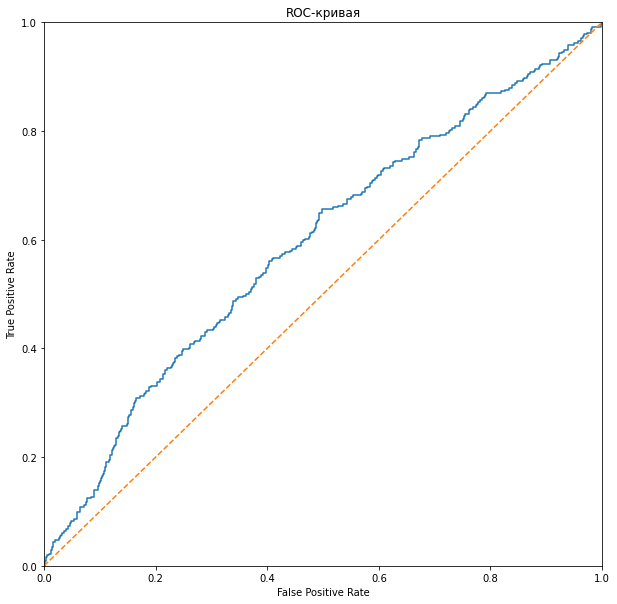

AUC: 0.5923289246487502


In [119]:
probabilities_valid = model.predict_proba(val[X])
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(val[y], probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(val[y], probabilities_one_valid)

print("AUC:", auc_roc)

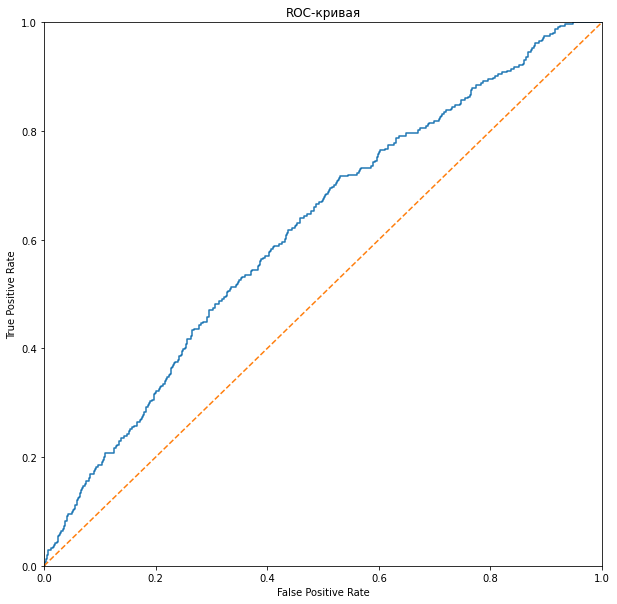

AUC: 0.617426006462568


In [120]:
probabilities_test = model.predict_proba(test[X])
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(test[y], probabilities_one_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(test[y], probabilities_one_test)

print("AUC:", auc_roc)

In [121]:
n_iters = model.best_iteration_ + 1

In [122]:
params = {'verbose':100, 
          'random_seed':1589, 
          'learning_rate':0.011, 
          'eval_metric': 'AUC', 
        'auto_class_weights': 'Balanced',
         'loss_function': 'Logloss',
         'iterations': n_iters}

In [123]:
model = CatBoostClassifier(**params)
model.fit(pool_train, eval_set=pool_val)

0:	test: 0.5842100	best: 0.5842100 (0)	total: 36.9ms	remaining: 24.2s
100:	test: 0.5818219	best: 0.5894680 (7)	total: 2.19s	remaining: 12.1s
200:	test: 0.5876468	best: 0.5894680 (7)	total: 4.42s	remaining: 10s
300:	test: 0.5899090	best: 0.5900604 (297)	total: 6.43s	remaining: 7.61s
400:	test: 0.5911275	best: 0.5911275 (400)	total: 8.58s	remaining: 5.48s
500:	test: 0.5914311	best: 0.5916057 (492)	total: 10.5s	remaining: 3.28s
600:	test: 0.5921144	best: 0.5923231 (569)	total: 12.6s	remaining: 1.17s
656:	test: 0.5923289	best: 0.5923289 (656)	total: 13.8s	remaining: 0us

bestTest = 0.5923289246
bestIteration = 656



In [124]:
test['all_features'] = model.predict(test[X])

In [125]:
print(classification_report(test[y],test['all_features']))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72      3556
           1       0.11      0.59      0.19       314

    accuracy                           0.58      3870
   macro avg       0.53      0.59      0.45      3870
weighted avg       0.87      0.58      0.68      3870



Модель не переобучилась поставив всем нули, но тем не менее показатель точности по искомому классу очень низкий.

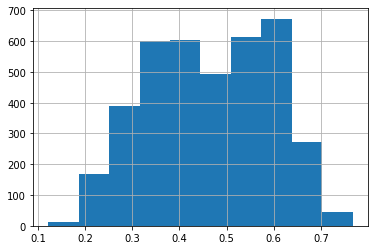

In [126]:
test['all_features_score'] = model.predict_proba(test[X])[:,1]
test['all_features_score'].hist()
plt.show()

In [127]:
roc_auc_score(test['debt'], test['all_features_score'])

0.617426006462568

Порог = 0.5 | Точность = 0.111 Полнота = 0.589 | F1-мера = 0.186
Порог = 0.51 | Точность = 0.112 Полнота = 0.57 | F1-мера = 0.187
Порог = 0.52 | Точность = 0.112 Полнота = 0.545 | F1-мера = 0.186
Порог = 0.53 | Точность = 0.117 Полнота = 0.532 | F1-мера = 0.192
Порог = 0.54 | Точность = 0.119 Полнота = 0.506 | F1-мера = 0.193
Порог = 0.55 | Точность = 0.122 Полнота = 0.475 | F1-мера = 0.194
Порог = 0.56 | Точность = 0.123 Полнота = 0.436 | F1-мера = 0.192
Порог = 0.57 | Точность = 0.123 Полнота = 0.398 | F1-мера = 0.188
Порог = 0.58 | Точность = 0.123 Полнота = 0.363 | F1-мера = 0.184
Порог = 0.59 | Точность = 0.122 Полнота = 0.309 | F1-мера = 0.174


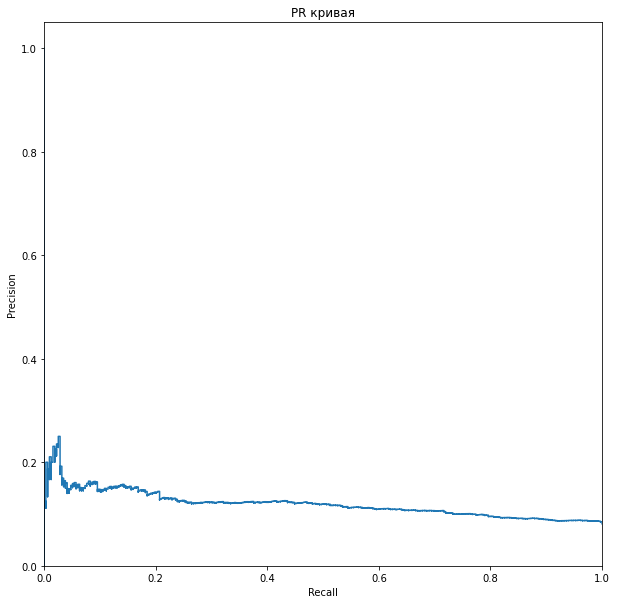

In [128]:
probabilities_valid = model.predict_proba(test[X])
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.5, 0.6, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(test[y], predicted_valid)
    recall = recall_score(test[y], predicted_valid)
    f1 = f1_score(test[y], predicted_valid)
    print(f"Порог = {round(threshold, 3)} | Точность = {round(precision, 3)} Полнота = {round(recall, 3)} | F1-мера = {round(f1, 3)}")

precision, recall, thresholds = precision_recall_curve(test[y], probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR кривая')
plt.show()

In [129]:
test['catboost_all_fin'] = (test['all_features_score'] > 0.54) * 1

In [130]:
print(classification_report(test[y],test['catboost_all_fin']))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      3556
           1       0.12      0.51      0.19       314

    accuracy                           0.66      3870
   macro avg       0.53      0.59      0.49      3870
weighted avg       0.87      0.66      0.73      3870



**Вывод** Удалось немного повысить F1 и Accuracy, но модель всё так же плохо прогнозирует дефолт заёмщика.

### Кросс-валидация

Так как объем датасета слишком мал, попробуем применить кросс-валидацию для улучшения качества обучения модели.
Для этого объединим обучающую и валидационную выборки.

In [131]:
train_full = pd.concat([train,val])

In [132]:
train_full_data = Pool(train_full[X],
                      label=train_full[y],
                      cat_features=cat_features)

In [133]:
params = {
          'random_seed':1589, 
          'learning_rate':0.0035, 
          'eval_metric': 'AUC', 
        'auto_class_weights': 'Balanced',
         'loss_function': 'Logloss',
         }

In [135]:
cv_data = cv(params = params,
            pool = train_full_data,
            fold_count = 9,
            shuffle = True,
            partition_random_seed = 1589, 
            stratified=False,
            verbose=False)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Training on fold [0/9]

bestTest = 0.6440098854
bestIteration = 992

Training on fold [1/9]

bestTest = 0.6622447992
bestIteration = 998

Training on fold [2/9]

bestTest = 0.6728034017
bestIteration = 891

Training on fold [3/9]

bestTest = 0.6165130524
bestIteration = 0

Training on fold [4/9]

bestTest = 0.6132689655
bestIteration = 1

Training on fold [5/9]

bestTest = 0.6497210732
bestIteration = 723

Training on fold [6/9]

bestTest = 0.573407694
bestIteration = 5

Training on fold [7/9]

bestTest = 0.6194553702
bestIteration = 3

Training on fold [8/9]

bestTest = 0.6233830777
bestIteration = 24



In [136]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
999,999,0.628627,0.031081,0.669017,0.010583,0.64428,0.00204


In [137]:
params = {'verbose':100, 
          'random_seed':1589, 
          'learning_rate':0.005, 
          'eval_metric': 'AUC', 
         'auto_class_weights': 'Balanced',
         'loss_function': 'Logloss',
         'iterations': 892}

In [138]:
model = CatBoostClassifier(**params)

In [139]:
model.fit(train_full_data)

0:	total: 31.3ms	remaining: 27.9s
100:	total: 2.59s	remaining: 20.3s
200:	total: 5.11s	remaining: 17.6s
300:	total: 7.66s	remaining: 15s
400:	total: 10.4s	remaining: 12.7s
500:	total: 12.9s	remaining: 10.1s
600:	total: 15.6s	remaining: 7.54s
700:	total: 18.2s	remaining: 4.95s
800:	total: 20.7s	remaining: 2.35s
891:	total: 22.9s	remaining: 0us


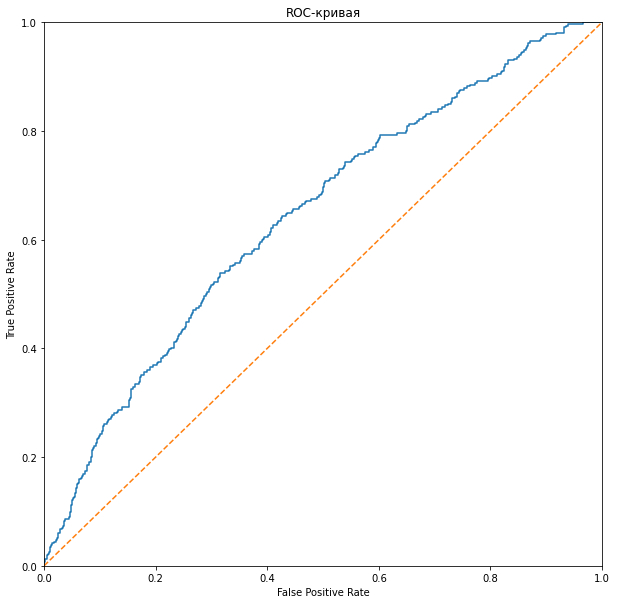

AUC: 0.6428463957928825


In [140]:
probabilities_valid = model.predict_proba(val[X])
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(val[y], probabilities_one_valid) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(val[y], probabilities_one_valid)

print("AUC:", auc_roc)

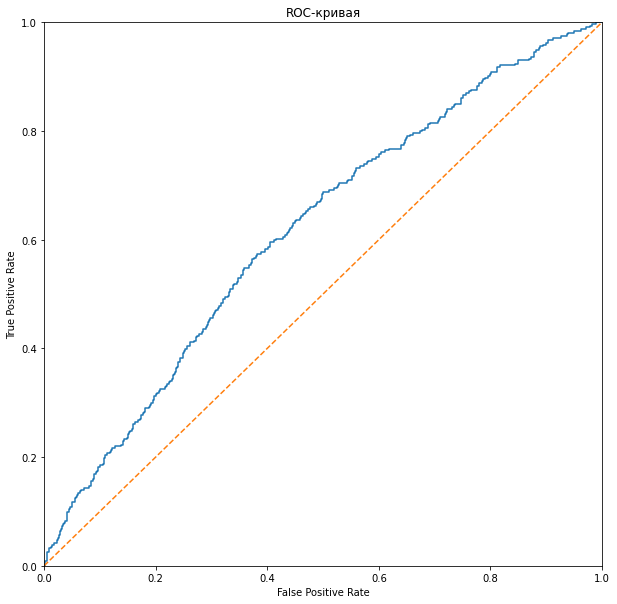

AUC: 0.6158148424122143


In [141]:
probabilities_test = model.predict_proba(test[X])
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(test[y], probabilities_one_test) 

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(test[y], probabilities_one_test)

print("AUC:", auc_roc)

In [142]:
test['cat_crosvall'] = model.predict(test[X])

In [143]:
profit_model(test['debt'], test['cat_crosvall'])

Accuracy: 0.5899224806201551
Recall: 0.5955414012738853
Precision: 0.1135397692774742
F1: 0.19071902090770013


In [144]:
test['cat_crosvall_score'] = model.predict_proba(test[X])[:,1]
roc_auc_score(test['debt'], test['cat_crosvall_score'])

0.6158148424122143

In [145]:
print(classification_report(test[y],test['cat_crosvall']))

              precision    recall  f1-score   support

           0       0.94      0.59      0.73      3556
           1       0.11      0.60      0.19       314

    accuracy                           0.59      3870
   macro avg       0.53      0.59      0.46      3870
weighted avg       0.88      0.59      0.68      3870



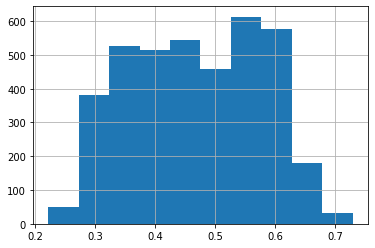

In [146]:
test['cat_crosvall_score'].hist()
plt.show()

Порог = 0.5 | Точность = 0.114 Полнота = 0.596 | F1-мера = 0.191
Порог = 0.5005 | Точность = 0.114 Полнота = 0.596 | F1-мера = 0.191
Порог = 0.501 | Точность = 0.114 Полнота = 0.596 | F1-мера = 0.191
Порог = 0.5015 | Точность = 0.114 Полнота = 0.596 | F1-мера = 0.192
Порог = 0.502 | Точность = 0.115 Полнота = 0.596 | F1-мера = 0.192
Порог = 0.5025 | Точность = 0.115 Полнота = 0.596 | F1-мера = 0.192
Порог = 0.503 | Точность = 0.114 Полнота = 0.589 | F1-мера = 0.191
Порог = 0.5035 | Точность = 0.114 Полнота = 0.586 | F1-мера = 0.191
Порог = 0.504 | Точность = 0.114 Полнота = 0.583 | F1-мера = 0.19
Порог = 0.5045 | Точность = 0.114 Полнота = 0.583 | F1-мера = 0.191
Порог = 0.505 | Точность = 0.114 Полнота = 0.583 | F1-мера = 0.191
Порог = 0.5055 | Точность = 0.115 Полнота = 0.583 | F1-мера = 0.191
Порог = 0.506 | Точность = 0.115 Полнота = 0.583 | F1-мера = 0.192
Порог = 0.5065 | Точность = 0.114 Полнота = 0.58 | F1-мера = 0.191
Порог = 0.507 | Точность = 0.114 Полнота = 0.576 | F1-мера 

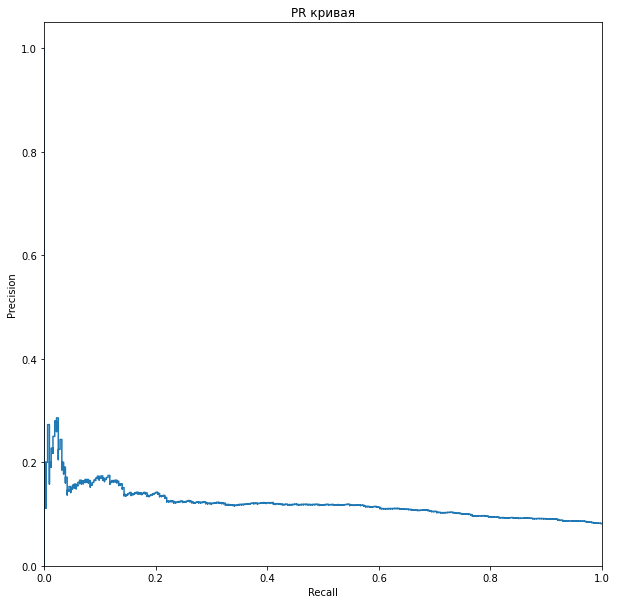

In [147]:
probabilities_valid = model.predict_proba(test[X])
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.5, 0.53, 0.0005):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(test[y], predicted_valid)
    recall = recall_score(test[y], predicted_valid)
    f1 = f1_score(test[y], predicted_valid)
    print(f"Порог = {round(threshold, 5)} | Точность = {round(precision, 3)} Полнота = {round(recall, 3)} | F1-мера = {round(f1, 3)}")

precision, recall, thresholds = precision_recall_curve(test[y], probabilities_valid[:, 1])    
plt.figure(figsize=(10, 10))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR кривая')
plt.show()

**Вывод** применение кросс-валидации не дало ощутимого эффекта. Модель все также плохо предсказывает просрочников.

### OverSampling

In [148]:
print(sorted(Counter(train['debt']).items()))

[(0, 10667), (1, 943)]


In [149]:
train_ones = train[train['debt'] == 1]
train_zeros = train[train['debt'] == 0]

In [150]:
print(train_ones.shape, train_zeros.shape, train.shape)

(943, 15) (10667, 15) (11610, 15)


In [151]:
X = train
Y = train['debt']

In [152]:
X.drop('debt', axis=1, inplace=True)

In [153]:

ros = RandomOverSampler(random_state=1589)
X_resampled, y_resampled = ros.fit_resample(X,Y)
y_resampled.mean() 

0.5

In [154]:
params = {'verbose':100, 
          'random_seed':1589, 
          'learning_rate':0.005, 
          'eval_metric': 'AUC', 
          'loss_function': 'Logloss',
         'iterations': n_iters}

In [155]:
X = ['children', 'days_employed', 'dob_years', 'education', 'family_status',
       'gender', 'income_type',  'total_income', 'purpose_category',
       'true_days']

cat_features = ['education', 'family_status',
       'gender', 'income_type', 'purpose_category'
        ]
y = ['debt']

In [156]:
train.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'family_status',
       'gender', 'income_type', 'total_income', 'purpose_category',
       'true_days', 'age_group', 'salary_group', 'years_emp',
       'years_emp_group'],
      dtype='object')

In [160]:
X_resampled.drop(columns=['age_group','salary_group', 'years_emp',
       'years_emp_group'], axis=1, inplace=True)

In [161]:
pool_train = Pool(data=X_resampled, label=y_resampled,
                  cat_features = cat_features)

In [162]:
model = CatBoostClassifier(**params)
model.fit(pool_train)

0:	total: 32.4ms	remaining: 21.3s
100:	total: 2.89s	remaining: 15.9s
200:	total: 5.59s	remaining: 12.7s
300:	total: 8.47s	remaining: 10s
400:	total: 11.6s	remaining: 7.42s
500:	total: 14.3s	remaining: 4.46s
600:	total: 17s	remaining: 1.58s
656:	total: 18.5s	remaining: 0us


In [163]:
test['y_score_cat_upsample'] = model.predict(test[X])

In [164]:
roc_auc_score(test['debt'], model.predict_proba(pool_test)[:,1])

0.6096567745910741

In [165]:
profit_model(test['debt'], test['y_score_cat_upsample'])

Accuracy: 0.6183462532299742
Recall: 0.5477707006369427
Precision: 0.11413404114134042
F1: 0.18890719384953322


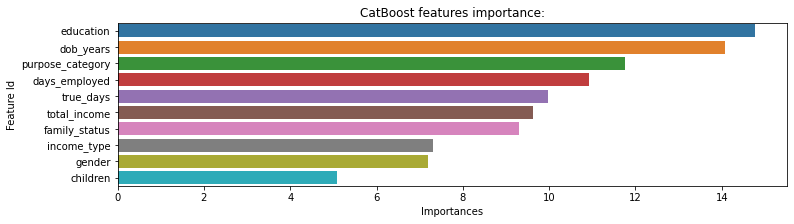

In [166]:
fi = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 3));
sns.barplot(x="Importances", y="Feature Id", data=fi);
plt.title('CatBoost features importance:');

In [167]:
print(classification_report(test[y],test['y_score_cat_upsample']))

              precision    recall  f1-score   support

           0       0.94      0.62      0.75      3556
           1       0.11      0.55      0.19       314

    accuracy                           0.62      3870
   macro avg       0.53      0.59      0.47      3870
weighted avg       0.87      0.62      0.70      3870



Upsample не дал ощутимых результатов.

## Вывод

В рамках задачи был рассмотрен и изучен датасет с информацией по банковским заёмщикам.
План решения:
1. Изучение датасета
2. Предобработка данных
3. Анализ данных
4. Машинное обучение

Особенности: 
- 10% пропусков по типу занятости и доходу
- Незначительные ошибки по количеству детей заемщика
- Значительные ошибки по трудовому стажу пенсионеров  

В рамках EDA были изучены все категории заёмщиков, по отдельным признакам выделены укрупненные категории. Дополнительно было рассмотрен каждый признак в контексте пола.
По результатам был определен целевой сегмент малорискового заёмщика:

**Пол:** Женский  
**Возраст(лет):** 42+  
**Образование:** высшее  
**Дети(шт):** нет детей   
**Семейное положение:** женат/замужем   
**Цель кредита:** недвижимость и свадьба    
**Тип занятости:**  пенсонер и госслужащий   
**Доход(руб):** 250-500 тыс. и 50-75 тыс.     
**Стаж(лет):**  10-25  

**Машинное обучение**
Не удалось настроить модель на высокую точность. В рамках улучшения качества были перепробованы:  
 - кросс-валидация
 - Оверсэмплинг
 
Значительного эффекта добиться не удалось. Модель в любом случае плохо предсказывает целевой признак.
**Предположительно данные в датасете синтетические, сам датасет создан для ЕДА и слабо применим для ML.**  